# Sentiment Analysis COVID19 in Indonesia

## Preparation

### Import Libraries

In [4]:
# Import Library Standard
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Import Library Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.pipeline import make_pipeline

# Import Library untuk Stemming
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [5]:
#pip install wordcloud
from wordcloud import WordCloud

In [6]:
# Read Dataset
data = pd.read_excel('/content/edo_LSTM.xlsx')
data.head()

,Mentions,Sentiment
0,RT @Moohd_Ilham: Jika dibandingkan dengan jala...,Positive
1,Laaah gua tim PSBB,Positive
2,RT Berdasarkan Peraturan Wali Kota Surabaya no...,Positive
3,@PRFMnews Ieu teh psbb atau lockdown sih ? Cum...,Negative
4,"RT ""Buat Mengobati Kangen Selama PSBB, Silahka...",Positive


### Data Exploration

In [7]:
df = data[['Mentions', 'Sentiment']].copy()
df.rename(columns={'Mentions':'komentar', 'Sentiment':'label'}, inplace=True)
print('Ukuran Dataset: ', df.shape)
df.head()

Ukuran Dataset:  (124503, 2)


,komentar,label
0,RT @Moohd_Ilham: Jika dibandingkan dengan jala...,Positive
1,Laaah gua tim PSBB,Positive
2,RT Berdasarkan Peraturan Wali Kota Surabaya no...,Positive
3,@PRFMnews Ieu teh psbb atau lockdown sih ? Cum...,Negative
4,"RT ""Buat Mengobati Kangen Selama PSBB, Silahka...",Positive


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


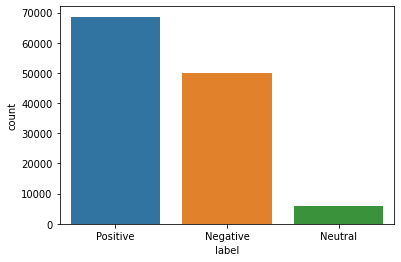

In [8]:
import seaborn as sns
sns.countplot(df['label']);

In [9]:
print("CONTOH KOMENTAR HASIL SCRAPPING\n")
for i in range(1,5):
      print(f"KOMENTAR{i}:\n {df['komentar'][i]}")

CONTOH KOMENTAR HASIL SCRAPPING

KOMENTAR1:
 Laaah gua tim PSBB
KOMENTAR2:
 RT Berdasarkan Peraturan Wali Kota Surabaya nomor 16 tahun 2020, ada beberapa poin yang dibatasi dan diperbolehkan dalam PSBB di Kota Surabaya. Berikut #InfografiSSnya. https://t.co/dNCTLX4UYt [RE e100ss]
KOMENTAR3:
 @PRFMnews Ieu teh psbb atau lockdown sih ? Cuma nanya ~
KOMENTAR4:
 RT "Buat Mengobati Kangen Selama PSBB, Silahkan Menikmati Ekspresi Ngangenin WTS Di Video"#Bukapuasa #kyutv #JanganCobaMudik #DisiplinKunciHadapiCorona #kangennaikkereta #ramadankareem #RamadanKareem2020 @one_vase @Mssgandra @marioleewook @CanduPijat @DMa


banyak komentar yang masih mengandung link http, spasi dan @akun sehingga perlu dibersihkan terlebih dahulu

## Preprocessing

### cleanning

In [10]:
def clean_tweet(tweet):
    """ cleaning tweet 
    source code: https://www.machinelearningplus.com/python/python-regex-tutorial-examples/
    """
    tweet = re.sub('http\S+\s*', '', tweet)  # remove URLs
    tweet = re.sub('pic\.\S+', '', tweet)  # remove picture twitter URLs
    tweet = re.sub('RT|cc', '', tweet)  # remove RT and cc
    tweet = re.sub('#\S+', '', tweet)  # remove hashtags
    tweet = re.sub('@\S+', '', tweet)  # remove mentions
    tweet = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', tweet)  # remove punctuations
    tweet = re.sub('\s+', ' ', tweet)  # remove extra whitespace
    return tweet

In [11]:
df['komentar'] = df['komentar'].apply(lambda x:clean_tweet(x))

In [12]:
for i in range(9,11):
    print(f"Contoh sebelum cleaning:\n\t{data['Mentions'][i]}")
    print(f"Contoh setelah cleaning:\n\t{df['komentar'][i]}\n")

Contoh sebelum cleaning:
	Di Indonesia?? Baru di PSBB aj sudah membosankan dan buru2 mudik...
Contoh setelah cleaning:
	Di Indonesia Baru di PSBB aj sudah membosankan dan buru2 mudik

Contoh sebelum cleaning:
	RT @e100ss: Risma Sosialisasikan PSBB di Pasar
https://t.co/rVHnybhilt [RE e100ss]
Contoh setelah cleaning:
	 Risma Sosialisasikan PSBB di Pasar RE e100ss



In [13]:
negatif_komen = df[df['label'] == 'Negative']['komentar'].values
neutral_komen = df[df['label'] == 'Neutral']['komentar'].values
positif_komen = df[df['label'] == 'Positive']['komentar'].values

### Spell Correction

#### Stemming

In [14]:
# Membuat stemmer
stemmerFactory = StemmerFactory()
stemmer = stemmerFactory.create_stemmer()

# Daftar Stopword
stopWordRemoverFactory = StopWordRemoverFactory()
stopwords = stopWordRemoverFactory.get_stop_words()

In [15]:
def word_cloud(x, stop=stopwords):
    words = WordCloud(width=3000, height=2000, stopwords=stop).generate(str(x))
    plt.figure(figsize=(40,30), edgecolor='k', facecolor='k')
    plt.imshow(words, interpolation='bilinear')
    plt.axis(False)
    plt.tight_layout(pad=0)
    plt.show()

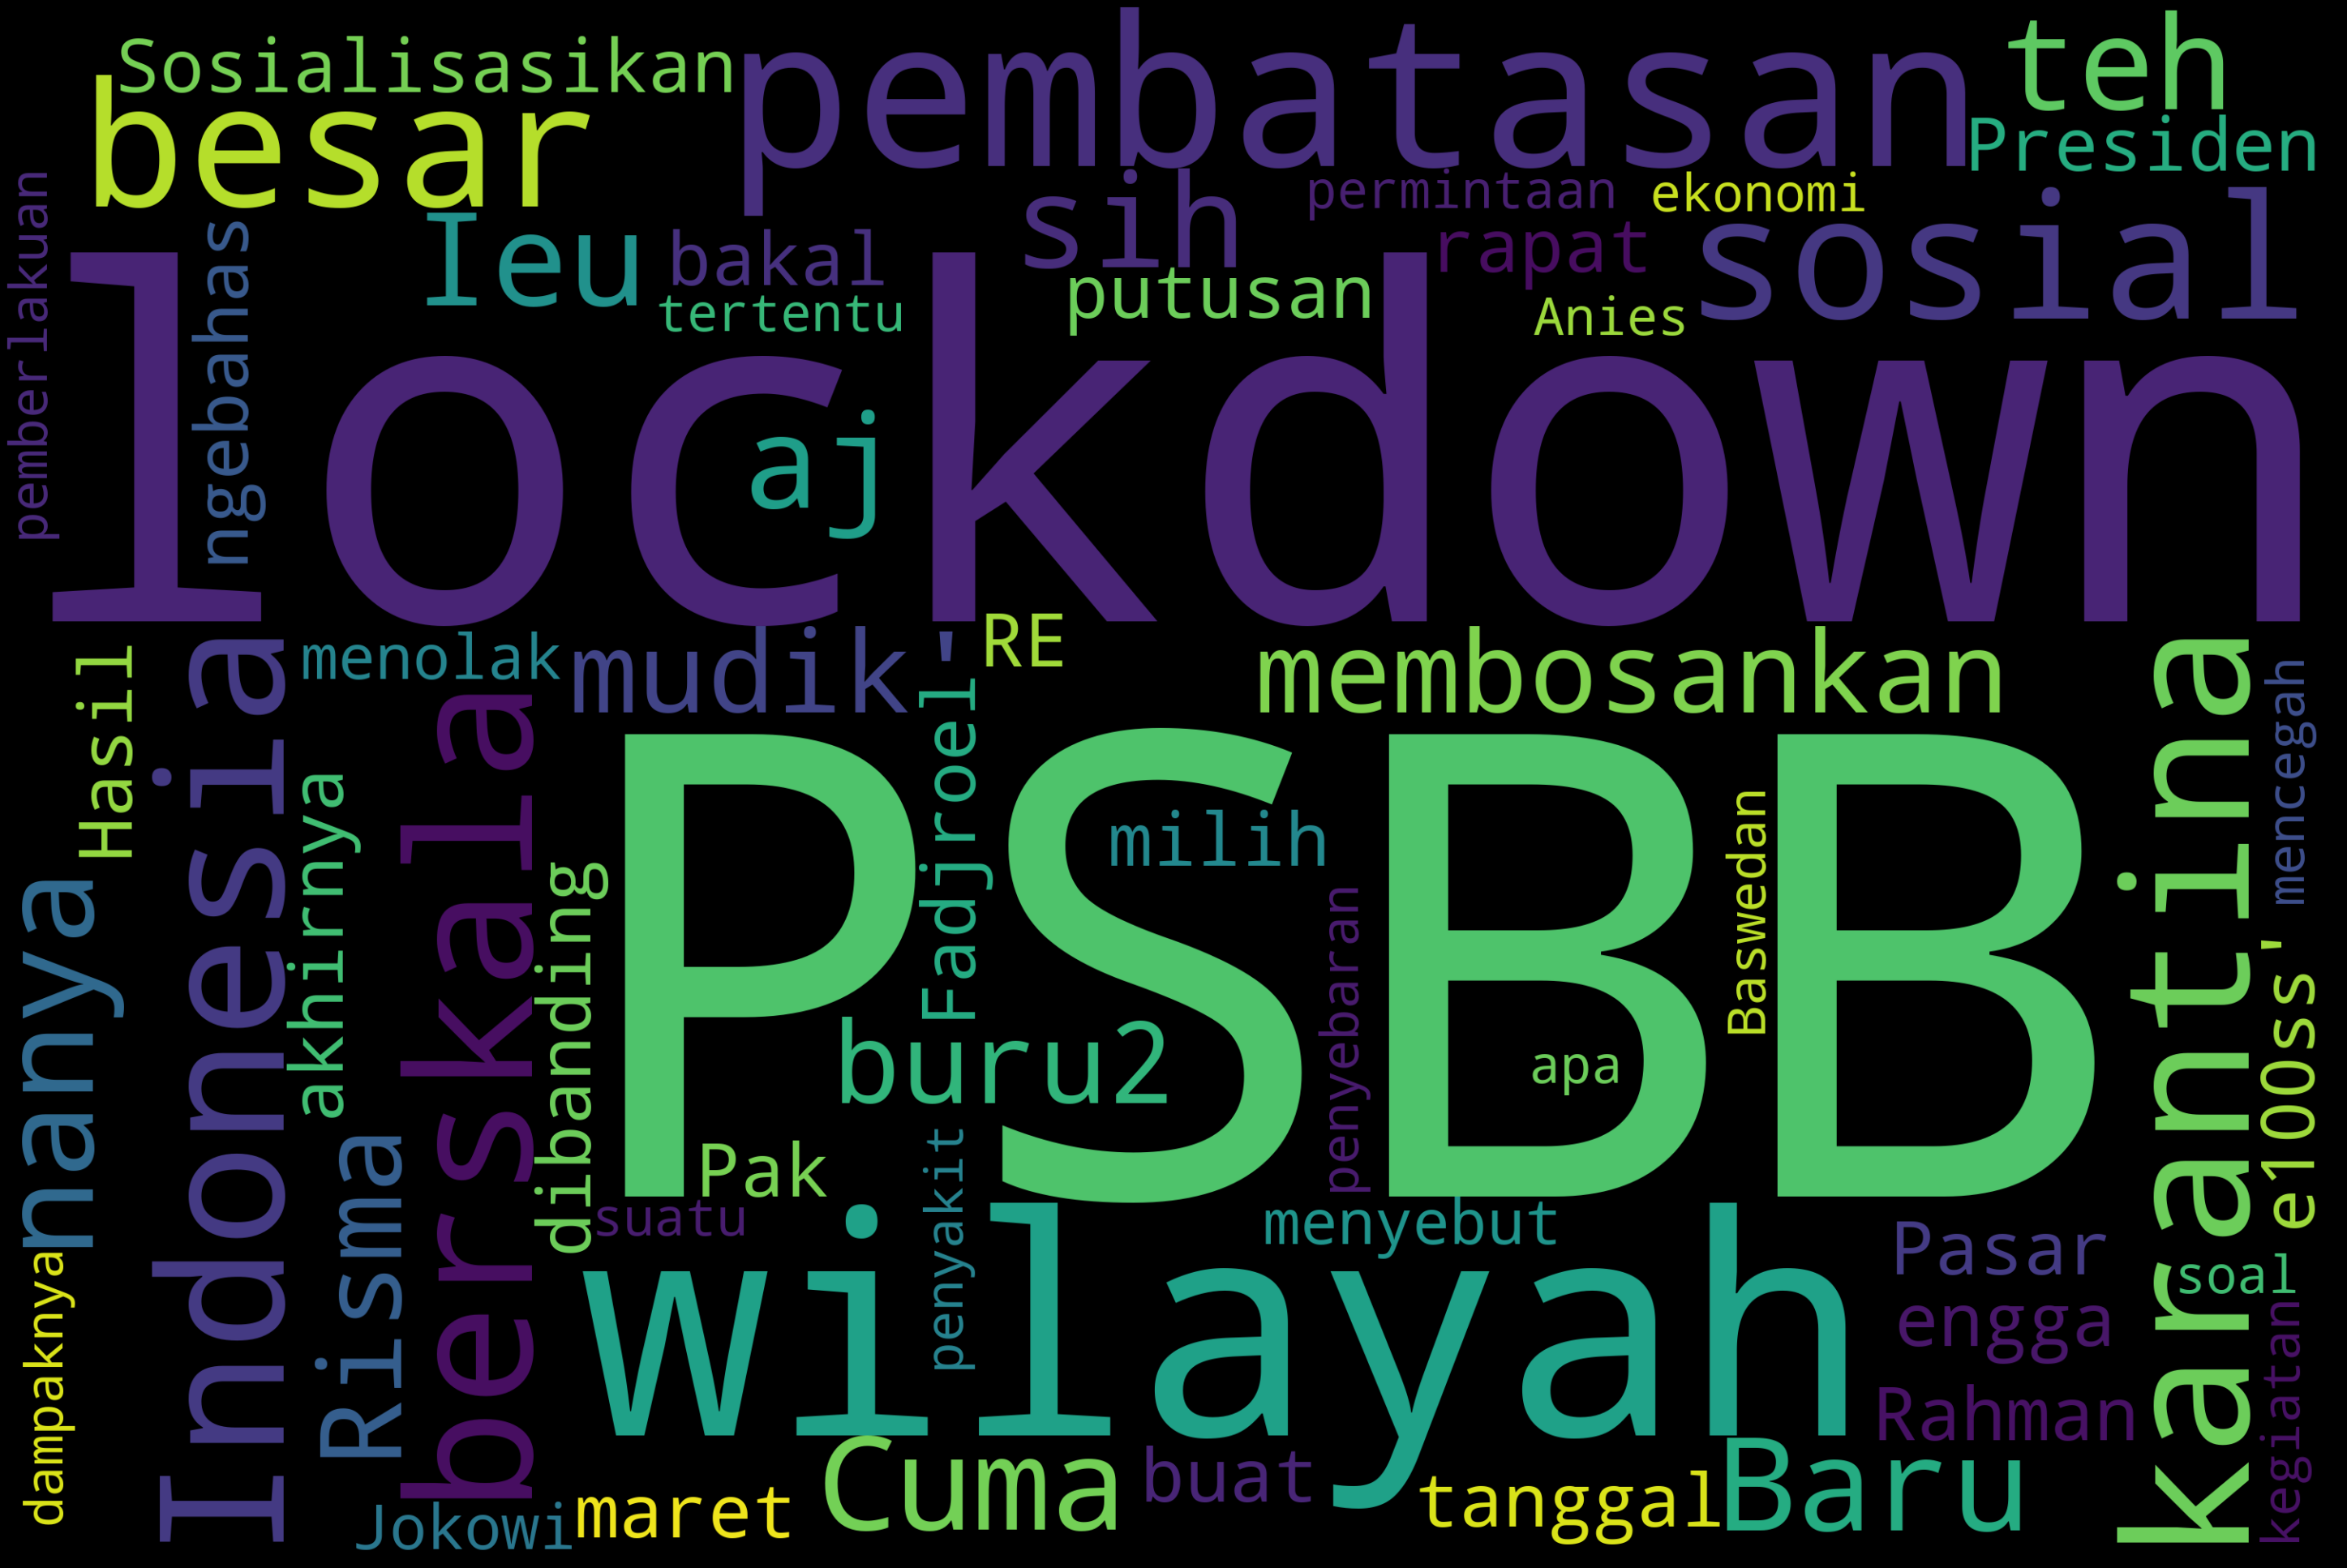

In [16]:
word_cloud(negatif_komen)

In [ ]:
word_cloud(neutral_komen)

In [ ]:
word_cloud(positif_komen)

In [ ]:
df['komentar'] = df['komentar'].apply(lambda x: stemmer.stem(x))

In [ ]:
for i in range(300, 310):
    print(f"sebelum stemming:\n {data['Mentions'][i]}")
    print(f"setelah stemming:\n {df['komentar'][i]}\n")

In [ ]:
df_clean = pd.DataFrame()
df_clean['Komentar_scraping'] = data['Mentions']
df_clean['Komentar_clean'] = df['komentar']
df_clean['label'] = df['label']
df_clean.head(5)

In [ ]:
df_clean.to_excel("cleaning_data.xlsx")